In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

In [2]:
# 点データ（NEのみ）のGeoJSONを読み込む
points = gpd.read_file("dwt_all.geojson")
points_ne = points[points["state"] == "NE"]

In [3]:
# site_no, year ごとに month が最小の行を抽出
filtered = points_ne.sort_values(by=['month']).groupby(['site_no', 'year'], as_index=False).first()

In [4]:
# site_noごとにデータ数をカウント
site_counts = filtered['site_no'].value_counts()

In [5]:
# 20年以上の観測年を持つ site_no を抽出
site_with_20yrs = site_counts[site_counts >= 20].index

In [6]:
# 3. 該当する site_no のデータだけを抽出
filtered_by20_points = filtered[filtered['site_no'].isin(site_with_20yrs)]

In [7]:
# dwtの最小値と最大値を使ってビンの境界を決める（幅10）
min_dwt = filtered_by20_points['dwt'].min()
max_dwt = filtered_by20_points['dwt'].max()
bins = np.arange(start=int(min_dwt // 10 * 10), stop=int(max_dwt // 10 * 10 + 20), step=10)

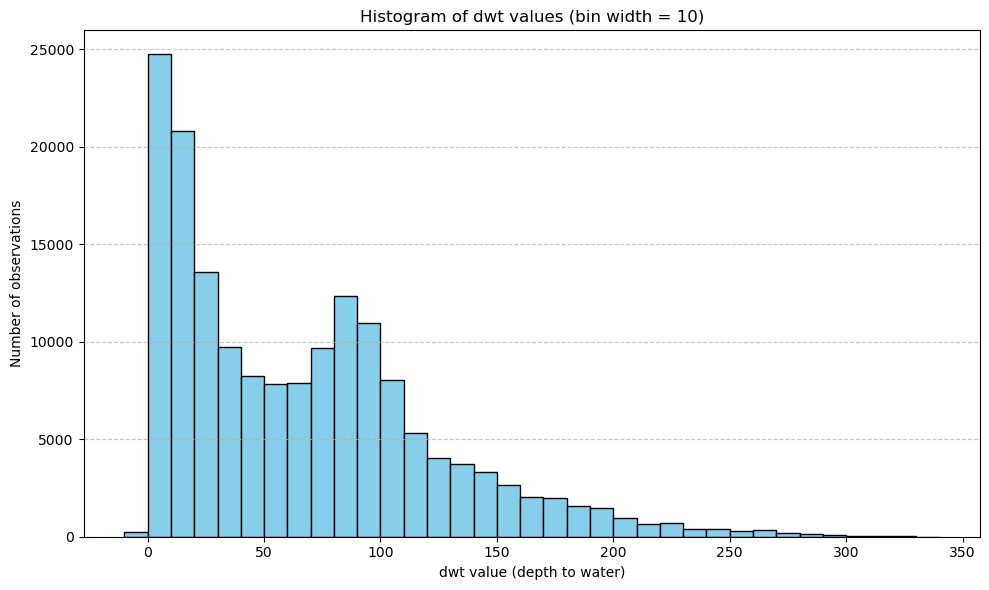

In [8]:
# プロット（ヒストグラム）
plt.figure(figsize=(10, 6))
plt.hist(filtered_by20_points['dwt'], bins=bins, color='skyblue', edgecolor='black')
plt.xlabel('dwt value (depth to water)')
plt.ylabel('Number of observations')
plt.title('Histogram of dwt values (bin width = 10)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
# dwtの範囲が [0, 300] にあるデータのみ抽出 (上のヒストグラムより決定)
filtered_by20_correctdata = filtered_by20_points[(filtered_by20_points['dwt'] >= 0) & (filtered_by20_points['dwt'] <= 300)]

In [10]:
# 時空間IDW
def spatiotemporal_idw(xytz, xi, yi, ti, power=2, alpha=1.0):
    """
    時空間IDW補間
    Parameters:
        xytz : ndarray (N, 4) → 観測点(x, y, t, z)
        xi, yi : 補間格子（2D meshgrid）
        ti : 補間する時間（スカラー、例：2020）
        power : 重み指数
        alpha : 時間軸の重要度（距離スケール比）
    Returns:
        zi : 補間値の2D配列（xi, yi と同形）
    """
    x, y, t, z = xytz[:, 0], xytz[:, 1], xytz[:, 2], xytz[:, 3]
    xi_flat = xi.flatten()
    yi_flat = yi.flatten()

    zi_flat = np.zeros_like(xi_flat)

    for i in range(len(xi_flat)):
        dx = xi_flat[i] - x
        dy = yi_flat[i] - y
        dt = ti - t

        dist2 = dx**2 + dy**2 + alpha * (dt**2)
        dist2[dist2 == 0] = 1e-10  # 0除算回避

        weights = 1 / dist2**(power / 2)
        zi_flat[i] = np.sum(weights * z) / np.sum(weights)

    return zi_flat.reshape(xi.shape)

In [11]:
# バッファとグリッド解像度
buffer = 0.2
grid_size = 100

In [12]:
# 補間マップのカラーバー範囲
vmin = 0
vmax = 300

In [13]:
# 最新年の次の年を予測
latest_year = int(filtered_by20_correctdata['year'].max())
target_year = latest_year + 1

# 補間範囲の設定
southern_limit = filtered_by20_correctdata.geometry.y.min()
miny = southern_limit
minx = filtered_by20_correctdata.geometry.x.min()
maxy = filtered_by20_correctdata.geometry.y.max()
maxx = filtered_by20_correctdata.geometry.x.max()

x_grid = np.linspace(minx - buffer, maxx + buffer, grid_size)
y_grid = np.linspace(miny, maxy + buffer, grid_size)
xi, yi = np.meshgrid(x_grid, y_grid)

# 時空間データ準備（全年のデータ）
xytz = np.array([
    [geom.x, geom.y, year, val]
    for geom, year, val in zip(filtered_by20_correctdata.geometry, filtered_by20_correctdata['year'], filtered_by20_correctdata['dwt'])
])

# 時空間IDWで補間
zi = spatiotemporal_idw(xytz, xi, yi, ti=target_year, power=2, alpha=1.0)
'''
# ポリゴン内だけを表示するためのマスク
grid_points = [Point(x, y) for x, y in zip(xi.flatten(), yi.flatten())]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=hpa.crs)
mask = grid_gdf.within(hpa.unary_union)
zi_masked = zi.flatten()
zi_masked[~mask] = np.nan
zi_masked = zi_masked.reshape(xi.shape)
'''

'\n# ポリゴン内だけを表示するためのマスク\ngrid_points = [Point(x, y) for x, y in zip(xi.flatten(), yi.flatten())]\ngrid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=hpa.crs)\nmask = grid_gdf.within(hpa.unary_union)\nzi_masked = zi.flatten()\nzi_masked[~mask] = np.nan\nzi_masked = zi_masked.reshape(xi.shape)\n'

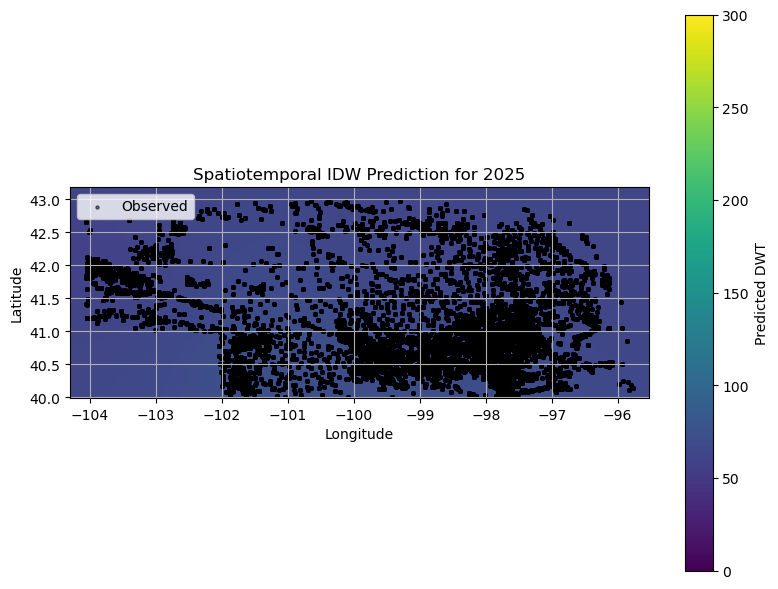

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

cmap = plt.get_cmap('viridis')
c = ax.pcolormesh(xi, yi, zi, cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)
plt.colorbar(c, ax=ax, label='Predicted DWT')

# 過去の観測点を表示
filtered_by20_correctdata.plot(ax=ax, color='black', markersize=5, alpha=0.5, label='Observed')

ax.set_title(f"Spatiotemporal IDW Prediction for {target_year}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()